In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# titanic data

Najpierw zaloguj się do https://www.kaggle.com/ i przejdź do wyzwania https://www.kaggle.com/c/titanic, aby pobrać 
 * train.csv i test.csv. 

Zapisz je w katalogu datasets/titanic.

In [3]:
import os
TITANIC_PATH = ''#os.path.join("datasets", "titanic")

In [4]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [5]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

* Dane są już podzielone na zestaw treningowy i zestaw testów. 
* Jednak dane testowe nie zawierają etykiet: Twoim celem jest wyszkolenie najlepszego modelu, który możesz wykorzystać w danych treningowych, następnie dokonanie swoich przewidywań na danych testowych i przesłanie ich do Kaggle, aby zobaczyć ostateczny wynik.

Rzućmy okiem na kilka pierwszych rzędów zestawu treningowego:

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

* Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* Pclass: passenger class.
* Name, Sex, Age: self-explanatory
* SibSp: how many siblings & spouses of the passenger aboard the Titanic.
* Parch: how many children & parents of the passenger aboard the Titanic.
* Ticket: ticket id
* Fare: price paid (in pounds)
* Cabin: passenger's cabin number
* Embarked: where the passenger embarked the Titanic
* Let's get more info to see how much data is missing:

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Atrybuty **Age**, **Cabin** oraz **Embarked** są czasami zerowe (mniej niż 891 wartości bez wartości null), szczególnie w przypadku **Cabin** (77% ma wartość zerową). Zignorujemy teraz **Cabin** i skupimy się na reszcie. Atrybut **Age** ma około 19% wartości pustych, więc będziemy musieli zdecydować, co z nimi zrobić. Zastąpienie wartości null medianą wieku wydaje się uzasadnione.

Atrybuty **Name** i **Ticket** mogą mieć pewną wartość, ale będą one nieco trudne do przekształcenia w użyteczne liczby. Na razie będziemy je ignorować.

Rzućmy okiem na atrybuty liczbowe:

In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Tylko 38% przeżyło: to wystarczająco blisko do 40%, więc **accuracy** będzie rozsądną miarą do oceny naszego modelu.

Sprawdźmy, czy etykiety przyjmują wartości 0 lub 1:

In [9]:
train_data['Survived'].unique()

array([0, 1])

Nie zapomnij o etykietach:

In [10]:
train_target = train_data['Survived'].values
train_data.drop('Survived', axis=1, inplace=True)
train_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
train_target

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

## Add additional features

In [12]:
train_data['NameParts'] = [len(v.split(' ')) for v in train_data['Name']]
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameParts
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,4
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,7
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,7
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4


In [13]:
test_data['NameParts'] = [len(v.split(' ')) for v in test_data['Name']]
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameParts
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,5
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,4
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,6


Teraz rzućmy okiem na wszystkie atrybuty kategoryczne:

In [14]:
from sklearn.compose import make_column_selector, ColumnTransformer

In [15]:
cat_names = make_column_selector(dtype_include=object)(train_data)
cat = train_data[cat_names]
cat[:5]

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [16]:
cat.isnull().sum()

Name          0
Sex           0
Ticket        0
Cabin       687
Embarked      2
dtype: int64

Atrybut **Embarked** mówi nam, gdzie pasażer zaokrętował: C = Cherbourg, Q = Queenstown, S = Southampton.

Teraz zbudujmy nasze **pipeline** preprocessingu. 

Wykorzystamy DataframeSelector aby wybrać określone atrybuty z DataFrame:

In [17]:
print(make_column_selector(dtype_include=object)(train_data))
cat_selector = ColumnTransformer([('selector', 'passthrough', make_column_selector(dtype_include=object)(train_data))], remainder='drop')
categorical = cat_selector.fit_transform(train_data)
categorical[:5]

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


array([['Braund, Mr. Owen Harris', 'male', 'A/5 21171', nan, 'S'],
       ['Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'female',
        'PC 17599', 'C85', 'C'],
       ['Heikkinen, Miss. Laina', 'female', 'STON/O2. 3101282', nan, 'S'],
       ['Futrelle, Mrs. Jacques Heath (Lily May Peel)', 'female',
        '113803', 'C123', 'S'],
       ['Allen, Mr. William Henry', 'male', '373450', nan, 'S']],
      dtype=object)

Zbudujmy **pipeline** dla atrybutów numerycznych:

In [18]:
num_cols = make_column_selector(dtype_include=np.number)(train_data)
print(num_cols)
pd.DataFrame(train_data[num_cols], columns=num_cols).isnull().sum()

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'NameParts']


PassengerId      0
Pclass           0
Age            177
SibSp            0
Parch            0
Fare             0
NameParts        0
dtype: int64

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [20]:
num_cols_ex = [v for v in make_column_selector(dtype_include=np.number)(train_data) if v != 'PassengerId']
print(num_cols_ex)

transformer = Pipeline([
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
])

num_pipeline = ColumnTransformer([('numerical', transformer, num_cols_ex)], remainder='drop')
numerical = num_pipeline.fit_transform(train_data)
numerical

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'NameParts']


array([[ 0.82737724, -0.56573646,  0.43279337, -0.47367361, -0.50244517,
        -0.05947423],
       [-1.56610693,  0.66386103,  0.43279337, -0.47367361,  0.78684529,
         2.5046327 ],
       [ 0.82737724, -0.25833709, -0.4745452 , -0.47367361, -0.48885426,
        -0.91417654],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337,  2.00893337, -0.17626324,
         0.79522808],
       [-1.56610693, -0.25833709, -0.4745452 , -0.47367361, -0.04438104,
        -0.05947423],
       [ 0.82737724,  0.20276197, -0.4745452 , -0.47367361, -0.49237783,
        -0.91417654]])

In [21]:
pd.DataFrame(numerical, columns=num_cols_ex).isnull().sum()

Pclass       0
Age          0
SibSp        0
Parch        0
Fare         0
NameParts    0
dtype: int64

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

Będziemy także potrzebować imputera do kategorycznych kolumn  napisowych (zwykły Imputer nie działa na tych kolumnach):

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

In [24]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
  most_frequent = None
  
  def fit(self, X, y=None):
    self.most_frequent = pd.Series([X[c].value_counts().idxmax() for c in X], 
                              index=X.columns)
    return self

  def transform(self, X, y=None):
    if self.most_frequent is None:
      raise 'Imputer have to be fited previously'
    return X.fillna(self.most_frequent)


Teraz możemy zbudować **pipeline** dla atrybutów kategorycznych:

In [25]:
train_data['Ticket'].unique()[:20]

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649'], dtype=object)

In [26]:
train_data['Cabin'].unique()[:100]

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101'], dtype=object)

In [27]:
train_data[['Cabin', 'Ticket']]

,Cabin,Ticket
0,NaN,A/5 21171
1,C85,PC 17599
2,NaN,STON/O2. 3101282
3,C123,113803
4,NaN,373450
...,...,...
886,NaN,211536
887,B42,112053
888,NaN,W./C. 6607
889,C148,111369


In [28]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

In [29]:
ohe_pipeline = Pipeline([('missing', MostFrequentImputer()), ('ohe', OneHotEncoder())])
lab_pipeline = Pipeline([('missing', MostFrequentImputer()), ('lab', OrdinalEncoder())])
lab_pipeline

Pipeline(memory=None,
         steps=[('missing', MostFrequentImputer()),
                ('lab',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>))],
         verbose=False)

In [30]:
cat_pipeline = ColumnTransformer(
    [
     ('one_hot_encoding', ohe_pipeline, ['Sex', 'Embarked'])
    #  ('label_encoding', lab_pipeline, ['Ticket', 'Cabin'])
     ], 
     remainder='drop')
cat_pipeline

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('one_hot_encoding',
                                 Pipeline(memory=None,
                                          steps=[('missing',
                                                  MostFrequentImputer()),
                                                 ('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True))],
                                          verbose=False),
                                 ['Sex', 'Embarked'])],
                  verbose=False)

In [31]:
train_data[['Sex', 'Ticket', 'Cabin', 'Embarked']].isnull().sum()

Sex           0
Ticket        0
Cabin       687
Embarked      2
dtype: int64

In [32]:
train_data[:5]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameParts
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,4
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,7
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,7
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4


In [33]:
cat_pipeline.fit(train_data)
cat = cat_pipeline.transform(train_data)#, columns = ['Sex', 'Ticket', 'Cabin', 'Embarked'])
cat

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

Na koniec połączmy powyższe podejścia:

In [34]:
from sklearn.pipeline import FeatureUnion

In [35]:
processing_pipeline = FeatureUnion(transformer_list=[
                                                     ('categorical_pipeline', cat_pipeline),
                                                     ('numerical_pipeline', num_pipeline)
                                                     ])

Teraz mamy fajny **pipeline** przetwarzania wstępnego, który pobiera dane wejściowe i zwraca dane wyjściowe złorzone z liczb, które możemy podać do dowolnego modelu uczenia maszynowego.

In [36]:
processing_pipeline.fit(train_data)
processed_data = processing_pipeline.transform(train_data)
processed_data[:5]

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.82737724, -0.56573646,  0.43279337, -0.47367361, -0.50244517,
        -0.05947423],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -1.56610693,  0.66386103,  0.43279337, -0.47367361,  0.78684529,
         2.5046327 ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.82737724, -0.25833709, -0.4745452 , -0.47367361, -0.48885426,
        -0.91417654],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -1.56610693,  0.4333115 ,  0.43279337, -0.47367361,  0.42073024,
         2.5046327 ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.82737724,  0.4333115 , -0.4745452 , -0.47367361, -0.48633742,
        -0.05947423]])

In [37]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

# Zad

Robimy StratifiedKFold i znajdujemy optymalne parametry dla

* SVM z jądrem rbf
* SVM z jądrem poly
* SVM liniowego
* Regresji logistycznej

In [38]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 

In [43]:
%%time
pipe = Pipeline(
    [
     ('processing', processing_pipeline),
     ('classifier', SVC())
    ]
)

param_grid = {
            'classifier__C': [1e3, 1e4, 1e5, 1e6, 1e7, 1e8],
            'classifier__gamma': [1e-4, 1e-3]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, n_jobs=-1)

grid_1.fit(train_data, train_target)

print(grid_1.best_params_)
# {'classifier__C': 100000000.0, 'classifier__gamma': 1e-08}
# {'classifier__C': 1000000.0, 'classifier__gamma': 1e-07}
# {'classifier__C': 1000000.0, 'classifier__gamma': 0.0001}

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0861s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0263s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.8min finished


{'classifier__C': 1000000.0, 'classifier__gamma': 0.0001}
CPU times: user 4.24 s, sys: 181 ms, total: 4.42 s
Wall time: 6min 50s


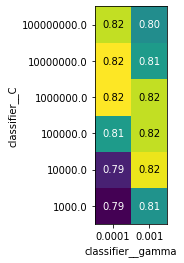

In [44]:
results = pd.DataFrame(grid_1.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['classifier__C']), -1)
# plot the mean cross-validation scores
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()


More detailed SVM rbf

In [ ]:
%%time
pipe = Pipeline(
    [
     ('processing', processing_pipeline),
     ('classifier', SVC())
    ]
)

param_grid = {
            'classifier__C': [2.45e6, 2.5e6, 2.55e6],
            'classifier__gamma': [9.8e-5, 1e-4, 1.2e-4]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, n_jobs=-1)

grid_1.fit(train_data, train_target)

print(grid_1.best_params_)
# {'classifier__C': 1000000.0, 'classifier__gamma': 0.0001}
# {'classifier__C': 2000000.0, 'classifier__gamma': 0.0001}
# {'classifier__C': 2500000.0, 'classifier__gamma': 0.0001}

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   28.2s finished


{'classifier__C': 2500000.0, 'classifier__gamma': 0.0001}
CPU times: user 1.79 s, sys: 22.5 ms, total: 1.81 s
Wall time: 29.3 s


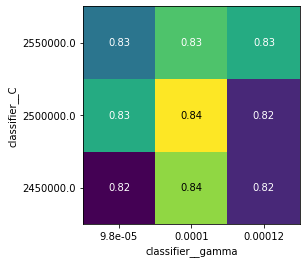

In [ ]:
results = pd.DataFrame(grid_1.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['classifier__C']), -1)
# plot the mean cross-validation scores
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()


In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
%%time
pipe = Pipeline(
    [
     ('processing', processing_pipeline),
     ('classifier', LogisticRegression())
    ]
)

param_grid = {
            'classifier__C': [0.017, 0.018, 0.019, 0.02, 0.1, 0.5],
            'classifier__penalty': [None, 'l1', 'l2', 'elasticnet']
}

grid_2 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, n_jobs=-1)

grid_2.fit(train_data, train_target)

print(grid_2.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1074s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0824s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1799s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.8s


{'classifier__C': 0.019, 'classifier__penalty': 'l2'}
CPU times: user 802 ms, sys: 21.8 ms, total: 824 ms
Wall time: 2.22 s


[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.2s finished


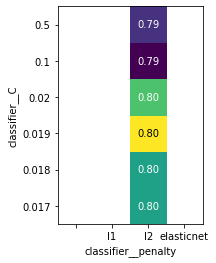

In [47]:
results = pd.DataFrame(grid_2.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['classifier__C']), -1)
# plot the mean cross-validation scores
heatmap(scores, xlabel='classifier__penalty', xticklabels=param_grid['classifier__penalty'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()


In [ ]:
%%time
pipe = Pipeline(
    [
     ('processing', processing_pipeline),
     ('classifier', SVC(kernel='poly'))
    ]
)

param_grid = {
            'classifier__C': [1e4, 1e5, 1e6, 1e7],
            'classifier__gamma': [1e-3, 1e-2, 1e-1]
}

grid_3 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, n_jobs=-1)

grid_3.fit(train_data, train_target)

print(grid_3.best_params_)

NameError: ignored

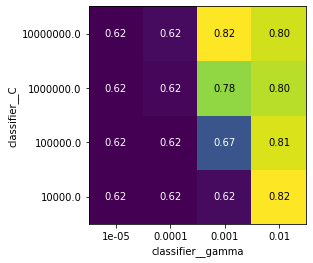

In [ ]:
results = pd.DataFrame(grid_3.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['classifier__C']), -1)
# plot the mean cross-validation scores
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()


In [48]:
from sklearn import  metrics


models = []
models.append(('SVM rbf', grid_1.best_estimator_))
models.append(('Logistic Regression', grid_2.best_estimator_))



precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(train_target, model.predict(train_data)) ))
    print("recall_score: {}".format( metrics.recall_score(train_target, model.predict(train_data)) ))
    print("f1_score: {}".format( metrics.f1_score(train_target, model.predict(train_data)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(train_target, model.predict(train_data)) ))
    precision_score.append(metrics.precision_score(train_target, model.predict(train_data)))
    recall_score.append(metrics.recall_score(train_target, model.predict(train_data)))
    f1_score.append( metrics.f1_score(train_target, model.predict(train_data)))
    accuracy_score.append(metrics.accuracy_score(train_target, model.predict(train_data)))

SVM rbf
precision_score: 0.823728813559322
recall_score: 0.7105263157894737
f1_score: 0.7629513343799058
accuracy_score: 0.8305274971941639
Logistic Regression
precision_score: 0.8036363636363636
recall_score: 0.6461988304093568
f1_score: 0.7163695299837926
accuracy_score: 0.8035914702581369


In [49]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM rbf', 'Logistic Regression'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,SVM rbf,0.823729,0.710526,0.762951,0.830527
1,Logistic Regression,0.803636,0.646199,0.716370,0.803591


In [50]:
model = grid_1.best_estimator_
model.fit(train_data, train_target)

Pipeline(memory=None,
         steps=[('processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 ColumnTransformer(n_jobs=None,
                                                                   remainder='drop',
                                                                   sparse_threshold=0.3,
                                                                   transformer_weights=None,
                                                                   transformers=[('one_hot_encoding',
                                                                                  Pipeline(memory=None,
                                                                                           steps=[('missing',
                                                                                                   MostFrequentImputer()),
                                             

In [51]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameParts
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,5
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,4
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,6


In [52]:
test_results = model.predict(test_data)
test_results

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [53]:
(test_results == 0).sum(), (test_results == 1).sum()

(264, 154)

In [54]:
output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': test_results})
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [55]:
output.to_csv('output.csv', index=False)

**0.77990**